<a href="https://colab.research.google.com/github/componavt/LLLE-R1900s/blob/main/src/visualization/grouped_bar_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Grouped Bar Chart: Annual Loan Volumes & Counts by Credit Type

Visualizes **annual dynamics** of selected credit categories across all settlements.

**Top bars (↑)** = total loan amount (in **thousands of rubles**)  
**Bottom bars (↓)** = total number of loans  

Each selected credit type is shown with:
- **Unique color**
- **Consistent style** for both amount and count (same color for ↑ and ↓)

✨ **Features:**
- 🌍 Fully bilingual: toggle between Russian (`ru`) and English (`en`)
- 📅 X-axis = years (e.g., 1913–1917)
- 🎨 Configurable credit types via `SELECTED_CREDIT_ITEMS`
- 📈 Dual-axis: positive (amount) and negative (count) bars share color per category
- 🖼️ Rendered directly in Google Colab

⚙️ Configure via:
- `USE_LANGUAGE` — `"ru"` or `"en"`
- `SELECTED_CREDIT_ITEMS` — list of `Name` values from `credit_items.csv`

⚙️ [2] Install Dependencies & Set Language + Credit Selection

In [ ]:
# Install dependencies for data processing and static plotting
!apt-get update -qq
!apt-get install -yqq libxcb-cursor0 libxcb-shm0 libxcb-xfixes0 libxcb-render0 libxcb-randr0 libxcb-glx0 libxkbcommon0

# We do NOT install kaleido or plotly>=6.1.1 since we'll use matplotlib for static output
!pip install -q python-dotenv pandas plotly matplotlib

# Clone the repo if running in Colab (optional — if data not uploaded manually)
import os

if not os.path.exists('LLLE-R1900s'):
    !git clone https://github.com/componavt/LLLE-R1900s.git
    %cd LLLE-R1900s
else:
    %cd LLLE-R1900s

# === LANGUAGE SWITCH ===
USE_LANGUAGE = "ru"
assert USE_LANGUAGE in ("ru", "en"), "USE_LANGUAGE must be 'ru' or 'en'"

# === SELECT CREDIT TYPES TO VISUALIZE ===
SELECTED_CREDIT_ITEMS = ["Migration", "CraftMaterials", "CraftTools"]

📥 [3] Load & Prepare Data

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv

# Validate SELECTED_CREDIT_ITEMS early (now that pandas is available)
valid_names = set(pd.read_csv('data/credit_items.csv')['Name'])
invalid = set(SELECTED_CREDIT_ITEMS) - valid_names
if invalid:
    raise ValueError(f"Invalid credit item(s): {invalid}. Must be from 'Name' column in credit_items.csv.")

# Load configuration
load_dotenv('config.env')

# Paths
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the output directory.")
    output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
print(f"Loading loan data from: {csv_path}")

# Load main loan data
df_loans = pd.read_csv(csv_path)
print(f"Loaded {len(df_loans)} loan records.")

# Load credit items
df_credit = pd.read_csv('data/credit_items.csv')
print(f"Loaded {len(df_credit)} credit item definitions.")

# --- Build credit item display label map ---
if USE_LANGUAGE == "ru":
    df_credit['display_label'] = df_credit['loan_short_ru']
else:
    df_credit['display_label'] = df_credit['Name']

label_map = dict(zip(df_credit['Name'], df_credit['display_label']))

# Filter loans to only selected credit items
df_loans = df_loans[df_loans['credit_item'].isin(SELECTED_CREDIT_ITEMS)].copy()

# Ensure numeric types
df_loans['amount_rubles'] = pd.to_numeric(df_loans['amount_rubles'], errors='coerce').fillna(0)
df_loans['loan_count'] = pd.to_numeric(df_loans['loan_count'], errors='coerce').fillna(0).astype(int)

print(f"Filtered to {len(df_loans)} records for selected credit types: {SELECTED_CREDIT_ITEMS}")

Loading loan data from: data/csv_out/loans_s28_i21.csv
Loaded 1768 loan records.
Loaded 21 credit item definitions.
Filtered to 264 records for selected credit types: ['Migration', 'CraftMaterials', 'CraftTools']


🔍 [4] Calculate Axis Extents and Prepare Annotations

In [3]:
# Aggregate by year and credit_item
df_annual = df_loans.groupby(['year', 'credit_item']).agg(
    total_amount=('amount_rubles', 'sum'),
    total_count=('loan_count', 'sum')
).reset_index()

df_annual['total_amount_k'] = df_annual['total_amount'] / 1000.0

years = sorted(df_annual['year'].unique())
credit_items = SELECTED_CREDIT_ITEMS

max_amount = df_annual['total_amount_k'].max() if not df_annual.empty else 1
max_count = df_annual['total_count'].max() if not df_annual.empty else 1

print(f"📈 Max loan amount (thsd rub): {max_amount:.2f}")
print(f"📊 Max loan count: {max_count}")

# --- Normalize both series to [-1, 1] range for visual balance ---
# We'll map [0, max_amount] → [0, 1] and [0, max_count] → [0, -1]
amount_norm = {}
count_norm = {}
amount_annotations = {}
count_annotations = {}

CREDIT_SYMBOLS = {
    "Migration": "🚶",
    "CraftMaterials": "🧵",
    "CraftTools": "🔨"
}

for item in credit_items:
    subset = df_annual[df_annual['credit_item'] == item]
    amount_dict = dict(zip(subset['year'], subset['total_amount_k']))
    count_dict = dict(zip(subset['year'], subset['total_count']))

    raw_amounts = [amount_dict.get(y, 0) for y in years]
    raw_counts = [count_dict.get(y, 0) for y in years]

    # Normalize
    norm_amounts = [a / max_amount if max_amount > 0 else 0 for a in raw_amounts]
    norm_counts = [-c / max_count if max_count > 0 else 0 for c in raw_counts]  # negative direction

    amount_norm[item] = norm_amounts
    count_norm[item] = norm_counts

    # Annotations show REAL values (not normalized)
    amount_annotations[item] = [f"{a:.1f}" if a > 0 else "" for a in raw_amounts]
    count_annotations[item] = [
        f"{CREDIT_SYMBOLS.get(item, '')}\n{int(c)}" if c > 0 else ""
        for c in raw_counts
    ]

# Store for cell 5
PLOT_DATA = {
    'years': years,
    'credit_items': credit_items,
    'amount_norm': amount_norm,
    'count_norm': count_norm,
    'amount_annotations': amount_annotations,
    'count_annotations': count_annotations,
    'max_amount': max_amount,
    'max_count': max_count
}

📈 Max loan amount (thsd rub): 9.56
📊 Max loan count: 249


📊 [5] Grouped Bar Chart: Annual Amount (↑) and Count (↓) by Credit Type
(Balanced Visual Scales and Custom Y-axis Labels)

In [10]:
import plotly
import plotly.graph_objects as go
import os

years = PLOT_DATA['years']
credit_items = PLOT_DATA['credit_items']
amount_norm = PLOT_DATA['amount_norm']
count_norm = PLOT_DATA['count_norm']
amount_annotations = PLOT_DATA['amount_annotations']
count_annotations = PLOT_DATA['count_annotations']
max_amount = PLOT_DATA['max_amount']
max_count = PLOT_DATA['max_count']

# Unicode symbols for legend
CREDIT_SYMBOLS = {
    "Migration": "🚶",
    "CraftMaterials": "🧵",
    "CraftTools": "🔨"
}

fig = go.Figure()

colors = plotly.colors.qualitative.Plotly

# Add traces (using normalized Y values)
for i, item in enumerate(credit_items):
    color = colors[i % len(colors)]
    base_label = label_map[item]
    symbol = CREDIT_SYMBOLS.get(item, "")
    legend_label = f"{base_label} {symbol}".strip()

    # Amount (normalized upward)
    fig.add_trace(go.Bar(
        x=years,
        y=amount_norm[item],
        name=legend_label,
        marker_color=color,
        offsetgroup=i,
        legendgroup=item,
        text=amount_annotations[item],
        textposition='outside',
        textfont=dict(size=10),
        hovertemplate=(
            (f"<b>{base_label}</b><br>Year: %{{x}}<br>Amount: %{{text}}k rub" if USE_LANGUAGE == "en"
             else f"<b>{base_label}</b><br>Год: %{{x}}<br>Сумма: %{{text}} тыс. руб.")
            + "<extra></extra>"
        )
    ))

    # Count (normalized downward)
    fig.add_trace(go.Bar(
        x=years,
        y=count_norm[item],
        name=legend_label,
        marker_color=color,
        opacity=0.75,
        offsetgroup=i,
        legendgroup=item,
        showlegend=False,
        text=count_annotations[item],
        textposition='outside',
        textfont=dict(size=10),
        hovertemplate=(
            (f"<b>{base_label}</b><br>Year: %{{x}}<br>Loans: %{{text.split()[-1]}}" if USE_LANGUAGE == "en"
             else f"<b>{base_label}</b><br>Год: %{{x}}<br>Ссуд: %{{text.split()[-1]}}")
            + "<extra></extra>"
        )
    ))

# --- Custom Y-axis tick labels ---
n_ticks_top = 5
tickvals_top = [i / (n_ticks_top - 1) for i in range(n_ticks_top)]
ticktext_top = [f"{(i / (n_ticks_top - 1)) * max_amount:.1f}" for i in range(n_ticks_top)]

n_ticks_bottom = 5
tickvals_bottom = [-i / (n_ticks_bottom - 1) for i in range(n_ticks_bottom)]
ticktext_bottom = [f"{int((i / (n_ticks_bottom - 1)) * max_count)}" for i in range(n_ticks_bottom)]

tickvals = tickvals_bottom[::-1][:-1] + tickvals_top
ticktext = ticktext_bottom[::-1][:-1] + ticktext_top

# Update layout
if USE_LANGUAGE == "en":
    yaxis_title = "Number of Loans ↓ / Amount (thsd rub) ↑"
    title = "Annual Loan Volume by Credit Type"
    legend_title_text = "Credit Type"
else:
    yaxis_title = "Число ссуд ↓ / Сумма (тыс. руб.) ↑"
    title = "Годовой объём ссуд по категориям"
    legend_title_text = "Тип ссуды"

fig.update_layout(
    title=title,
    barmode='group',
    xaxis=dict(
        title="Year" if USE_LANGUAGE == "en" else "Год",
        tickmode='linear'
    ),
    yaxis=dict(
        title=yaxis_title,
        tickmode='array',
        tickvals=tickvals,
        ticktext=ticktext,
        range=[-1.1, 1.1],
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='black'
    ),
    legend=dict(
        title=legend_title_text,
        traceorder="normal",
        x=0.01,          # X-позиция: 0 = левый край, 0.01 = небольшой отступ
        y=0.99,          # Y-позиция: 1 = верхний край, 0.99 = небольшой отступ сверху
        xanchor='left',  # Якорь по X — слева
        yanchor='top',   # Якорь по Y — сверху
        bgcolor='rgba(255, 255, 255, 0.8)',  # Полупрозрачный белый фон для читаемости
        bordercolor='black',
        borderwidth=0.5
    ),
    height=650,
    font=dict(size=12)
)

# Show in Colab
fig.show(renderer="colab")

print(f"\n✅ Displayed balanced grouped bar chart for {len(credit_items)} credit types.")


✅ Displayed balanced grouped bar chart for 3 credit types.


📊 [6] Static Grouped Bar Chart using Matplotlib (no emoji, Balanced Scales, Custom Hatch, and Positive Y Labels)


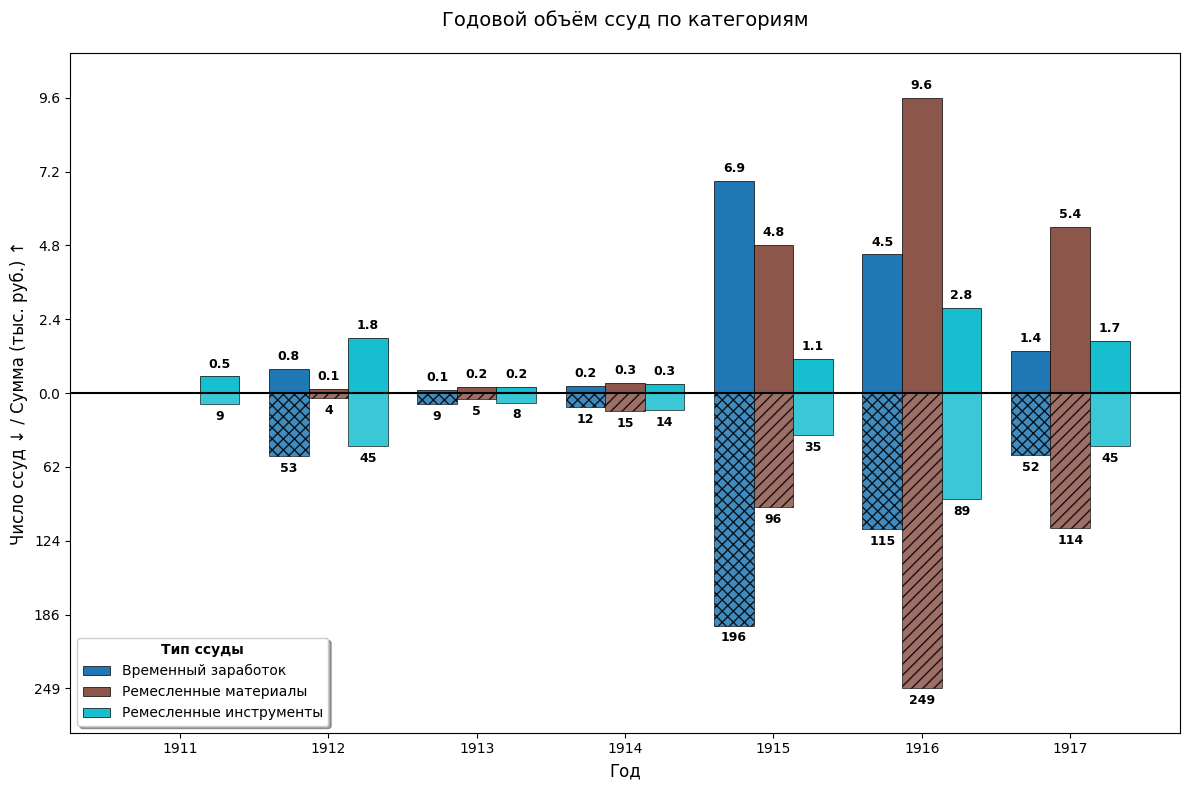


✅ Balanced chart saved as: figures/grouped_bar_chart_Migration_CraftMaterials_CraftTools_ru.png


In [9]:
# 📊 [6] Static Grouped Bar Chart using Matplotlib (Balanced Scales via Normalization)

import matplotlib.pyplot as plt
import numpy as np
import os

# Use normalized data prepared in cell [4] for visual balance
years = PLOT_DATA['years']
credit_items = PLOT_DATA['credit_items']
amount_norm = PLOT_DATA['amount_norm']  # Already normalized to [0, 1]
count_norm = PLOT_DATA['count_norm']    # Already normalized to [0, -1]
amount_annotations = PLOT_DATA['amount_annotations']  # Real values as strings
count_annotations = PLOT_DATA['count_annotations']    # Real values as strings

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

n_years = len(years)
n_items = len(credit_items)
total_width = 0.8
bar_width = total_width / n_items
x = np.arange(n_years)

colors = plt.cm.tab10(np.linspace(0, 1, n_items))

# Define hatch patterns per credit item
HATCH_MAP = {
    "CraftTools": "",        # solid
    "CraftMaterials": "///", # diagonal lines
    "Migration": "xxx"       # crosses
}

# Plot upward bars (normalized amount: [0, 1])
for i, item in enumerate(credit_items):
    offset = (i - n_items / 2) * bar_width + bar_width / 2
    bars = ax1.bar(
        x + offset,
        amount_norm[item],
        width=bar_width,
        label=label_map[item],
        color=colors[i],
        edgecolor='black',
        linewidth=0.5
    )
    # Add amount labels (real values from annotations)
    for j, (bar, val_str) in enumerate(zip(bars, amount_annotations[item])):
        if val_str:  # Only if there's a value to show
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.02,  # Small offset in normalized units
                val_str,
                ha='center', va='bottom', fontsize=9, fontweight='bold'
            )

# Plot downward bars (normalized count: [0, -1])
for i, item in enumerate(credit_items):
    offset = (i - n_items / 2) * bar_width + bar_width / 2
    hatch = HATCH_MAP.get(item, "")
    bars = ax1.bar(
        x + offset,
        count_norm[item],
        width=bar_width,
        color=colors[i],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.85,
        hatch=hatch
    )
    # Add count labels (real values from annotations)
    for j, (bar, cnt_str) in enumerate(zip(bars, count_annotations[item])):
        if cnt_str:  # Only if there's a value to show
            # Split to get just the number part (remove emoji if present)
            num_part = cnt_str.split('\n')[-1] if '\n' in cnt_str else cnt_str
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - 0.02,  # Small offset in normalized units
                num_part,
                ha='center', va='top', fontsize=9, fontweight='bold'
            )

# === SET BALANCED Y-AXIS LIMITS ===
# Since data is normalized to [-1, 1], we set symmetric limits
ax1.set_ylim(-1.15, 1.15)

# === CUSTOM Y-AXIS TICKS: Map normalized positions to real values ===
max_amount = PLOT_DATA['max_amount']
max_count = PLOT_DATA['max_count']

# Top ticks: normalized positions [0, 1] → real amount [0, max_amount]
n_ticks_top = 5
norm_top_vals = np.linspace(0, 1, n_ticks_top)
real_top_vals = norm_top_vals * max_amount
top_labels = [f"{v:.1f}" for v in real_top_vals]

# Bottom ticks: normalized positions [-1, 0] → real count [max_count, 0]
n_ticks_bottom = 5
norm_bottom_vals = np.linspace(-1, 0, n_ticks_bottom)
real_bottom_vals = -norm_bottom_vals * max_count  # Make positive
bottom_labels = [f"{int(v)}" for v in real_bottom_vals]

# Combine ticks (avoid duplicate 0 at center)
tick_positions = list(norm_bottom_vals[:-1]) + list(norm_top_vals)
tick_labels = bottom_labels[:-1] + top_labels

ax1.set_yticks(tick_positions)
ax1.set_yticklabels(tick_labels)

# Labels and titles (with updated order)
if USE_LANGUAGE == "en":
    ax1.set_ylabel('Number of Loans ↓ / Amount (thsd rub) ↑', fontsize=12)
    ax1.set_xlabel('Year', fontsize=12)
    title = "Annual Loan Volume by Credit Type"
    legend_title = "Credit Type"
else:
    ax1.set_ylabel('Число ссуд ↓ / Сумма (тыс. руб.) ↑', fontsize=12)
    ax1.set_xlabel('Год', fontsize=12)
    title = "Годовой объём ссуд по категориям"
    legend_title = "Тип ссуды"

ax1.set_title(title, fontsize=14, pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Zero line at normalized y=0
ax1.axhline(0, color='black', linewidth=1.5)

# Legend
legend = ax1.legend(
    title=legend_title,
    loc='lower left',
    frameon=True,
    fancybox=True,
    shadow=True
)
legend.get_title().set_fontweight('bold')

plt.tight_layout()

# Save
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
items_str = "_".join(SELECTED_CREDIT_ITEMS)
lang_suffix = "en" if USE_LANGUAGE == "en" else "ru"
filename = f"grouped_bar_chart_{items_str}_{lang_suffix}.png"
filepath = os.path.join(output_dir, filename)

plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Balanced chart saved as: {filepath}")

🌟 [4] Individual Settlement Charts

📓 Ячейка 4: Отдельные диаграмма по всем поселениям (ещё карту бы...)